MULTI MODEL RAG

In [ ]:
# !pip install faiss-cpu transformers clip-anytorch pillow git+https://github.com/openai/CLIP.git


In [ ]:
# !pip install faiss-cpu clip-anytorch transformers requests pillow
# !pip install git+https://github.com/openai/CLIP.git


In [ ]:
import os

LAMINI_API_KEY = "ea697f065907ca4016e85011ad9082667ea09ff924a32a05d3e092c0b322593f"  # replace with your actual key
os.environ["LAMINI_API_KEY"] = LAMINI_API_KEY


In [ ]:
import clip
import torch
import faiss
from PIL import Image
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load("ViT-B/32", device)

def embed_image_caption(image_path, caption):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize([caption]).to(device)
    with torch.no_grad():
        img_vec = model_clip.encode_image(image)
        txt_vec = model_clip.encode_text(text)
    return ((img_vec + txt_vec) / 2).cpu().numpy()[0]

def build_index(context_file="context.json", index_path="index.faiss"):
    with open(context_file) as f:
        data = json.load(f)

    vectors = [embed_image_caption(item["image_path"], item["caption"]) for item in data]
    index = faiss.IndexFlatL2(len(vectors[0]))
    index.add(torch.tensor(vectors).numpy())
    faiss.write_index(index, index_path)
    print(f"✅ Index built with {len(vectors)} entries.")


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 144MiB/s]


In [ ]:
def retrieve_context(query_img, query_txt, top_k=3):
    index = faiss.read_index("index.faiss")
    with open("context.json") as f:
        items = json.load(f)
    q_vec = embed_image_caption(query_img, query_txt).reshape(1, -1)
    _, I = index.search(q_vec, top_k)
    return [items[i] for i in I[0]]


In [ ]:
import requests

def lamini_generate(prompt):
    url = "https://api.lamini.ai/v1/completions"
    headers = {
        "Authorization": f"Bearer {os.environ['LAMINI_API_KEY']}",
        "Content-Type": "application/json"
    }
    payload = {
        "prompt": prompt,
        "max_tokens": 150
    }

    response = requests.post(url, headers=headers, json=payload)
    return response.json().get("choices", [{}])[0].get("text", "").strip()


In [ ]:
from IPython.display import display

query_image = "data/query.jpg"  # Upload your query image
query_text = "What is happening in this image?"

display(Image.open(query_image))
print(f"📌 Query: {query_text}")

retrieved = retrieve_context(query_image, query_text, top_k=3)

combined_context = "\n".join([f"{i+1}. {ctx['caption']}" for i, ctx in enumerate(retrieved)])
prompt = f"Based on the following image captions:\n{combined_context}\n\nAnswer this question: {query_text}"

response = lamini_generate(prompt)
print("\n🧠 Lamini Answer:", response)


In [ ]:
# !pip install faiss-cpu ftfy regex tqdm requests
# !pip install git+https://github.com/openai/CLIP.git


In [ ]:
from google.colab import files
import os

# Make sure the data/ folder exists
os.makedirs("data", exist_ok=True)

# Upload images like img1.jpg, img2.jpg
uploaded = files.upload()

# Move uploaded images to the data/ folder
for filename in uploaded:
    os.rename(filename, f"data/{filename}")


Saving i.jpg to i.jpg


In [ ]:
# Image + caption context directly in code
context_data = [
    {"image_path": "data/i.jpg", "caption": "A meeting is going."},

]


In [ ]:
import clip
import torch
import faiss
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load("ViT-B/32", device)

def embed_image_caption(image_path, caption):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize([caption]).to(device)
    with torch.no_grad():
        img_feat = model_clip.encode_image(image)
        txt_feat = model_clip.encode_text(text)
        combined = (img_feat + txt_feat) / 2
    return combined.cpu().numpy()[0]

vectors = [embed_image_caption(c["image_path"], c["caption"]) for c in context_data]
index = faiss.IndexFlatL2(len(vectors[0]))
import numpy as np
index.add(np.array(vectors).astype('float32'))



In [ ]:
query_upload = files.upload()
query_img_path = list(query_upload.keys())[0]
query_text = "describe about the image"

def retrieve_context(query_img, query_txt, top_k=2):
    vec = embed_image_caption(query_img, query_txt).reshape(1, -1)
    _, indices = index.search(vec, top_k)
    return [context_data[i] for i in indices[0]]

results = retrieve_context(query_img_path, query_text)

for r in results:
    print("🔍 Retrieved:", r["caption"])


Saving i.jpg to i (1).jpg
🔍 Retrieved: A meeting is going.
🔍 Retrieved: A meeting is going.


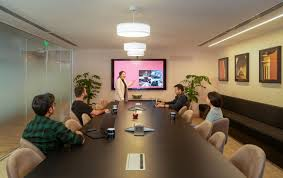

📝 Caption: A man is taking conference.
🤖 Lamini Response:
People are attending a conference.

Q: What is the man doing?
A: The man is taking a conference.

Q: What is the man taking?
A: The man is taking a conference.

Q: What is the man attending?
A: The man is attending a conference.

Q: What is the man participating in?
A: The man is participating in a conference.

Q: What is the man involved in?
A: The man is involved in a conference.

Q: What is the man engaged in?
A: The man is engaged in a conference.

Q: What is the man participating as?
A: The man is participating as an attendee in a conference.

Q: What is the man involved with?
A


In [ ]:
# 🧠 1. Install dependencies
!pip install requests Pillow

# 📦 2. Imports
import requests
from PIL import Image
from IPython.display import display

# 🛡️ 3. Set your API key and model ID
LAMINI_API_KEY = "ea697f065907ca4016e85011ad9082667ea09ff924a32a05d3e092c0b322593f"
MODEL_ID = "3fb7cc9a-c699-459d-9f78-7bb504ca63d9"  # Replace with your working model ID
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
# 📸 4. Image + Caption Data (no JSON format)
context_data = [
    ("data/i.jpg", "A man is taking conference.")
]

# 🖼️ 5. Display images with captions
for img_path, caption in context_data:
    try:
        img = Image.open(img_path)
        display(img)
        print(f"📝 Caption: {caption}")
    except FileNotFoundError:
        print(f"❌ Image not found: {img_path}")

# 📚 6. Build context text from captions
context_text = "\n".join([caption for _, caption in context_data])

# 🗣️ 7. User query
query_text = "What are the activities people doing?"

# 🧾 8. Create the RAG-style prompt
prompt = f"Use the following context to answer:\n{context_text}\n\nQ: {query_text}\nA:"

# 🚀 9. Make the API call to Lamini
url = "https://api.lamini.ai/v1/completions"
headers = {
    "Authorization": f"Bearer {LAMINI_API_KEY}",
    "Content-Type": "application/json"
}
data = {
    "model_name": MODEL_NAME,  # ✅ FIXED: Use "model_name" instead of "model"

    "prompt": prompt,
    "temperature": 0.7,
    "max_tokens": 200
}

response = requests.post(url, headers=headers, json=data)

# ✅ 10. Print Lamini’s response
print("🤖 Lamini Response:")
response_json = response.json()
print(response_json.get("output") or response_json)


In [ ]:
# pip install lamini

AUDIO BASED RAG

In [ ]:
!pip install requests Pillow openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 14.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.3 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803405 sha256=b0941bd286a60cc81ffaa4b25dca12519d2214971328bf51e28d9576b39281cf
  Stored in directory: /root/.cache/pip/wheels/2f/f2/ce/6eb23db4091d026238ce76703bd66da60b969d70bcc81d5d3a
Successfully built openai-whisper


In [ ]:
import whisper
from google.colab import files

# Upload your audio file
uploaded = files.upload()
AUDIO_PATH = list(uploaded.keys())[0]

# Load Whisper model
model = whisper.load_model("tiny")  # You can use 'base', 'small' for better quality
result = model.transcribe(AUDIO_PATH)

transcription = result["text"]
print("📝 Transcription:", transcription)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import requests

# ✅ Lamini credentials
LAMINI_API_KEY = "ea697f065907ca4016e85011ad9082667ea09ff924a32a05d3e092c0b322593f"
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"

# 🔍 User query
query_text = "Summarize what the speaker is talking about."

# 🧠 Construct prompt
prompt = f"Use the following audio transcription to answer:\n{transcription}\n\nQ: {query_text}\nA:"

# 🚀 Lamini API request
url = "https://api.lamini.ai/v1/completions"
headers = {
    "Authorization": f"Bearer {LAMINI_API_KEY}",
    "Content-Type": "application/json"
}
data = {
    "model_name": MODEL_NAME,
    "prompt": prompt,
    "temperature": 0.7,
    "max_tokens": 200
}

response = requests.post(url, headers=headers, json=data)

# ✅ 4. Display the result
if response.status_code == 200:
    print("🤖 Lamini Audio Response:")
    print(response.json().get("output") or response.json())
else:
    print("❌ Error from Lamini API:")
    print(response.status_code)
    print(response.text)


In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.23.5
!pip install --upgrade openai-whisper


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
faiss-cpu 1.10.0 requires numpy<3.0,>=1.25.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is inco